# Generate emissions scenarios

Here, we check that we can reproduce the baseline results of AR6 using SSP2-4.5 in FaIR, and export the emissions scenarios that we want to run our modified scenarios with.

We see that according to UNFCCC NDC Synthesis Report (https://unfccc.int/sites/default/files/resource/cma2021_08_adv_1.pdf), SSP2-4.5 is quite in line with NDC projections to 2030. So, we use this as our baseline scenario.

In [1]:
import copy

from climateforcing.utils import mkdir_p
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
emissions_out = {}
scenarios = ["ssp245", "ch4_30", "ch4_40", "ch4_50", "co2afolu_0", "coal-phase-out", "all"]

## Put into a FaIR-style input array

Some unit conversion required first. We define SSP2-4.5 for each scenario first, then overwrite the specific entries we want to change.

In [3]:
ssp_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-world-ssp245-v5-1-0.csv')
years = np.arange(1750, 2111)

startyear = 1750
first_scenyear = 2015
last_scenyear = 2110
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

for scenario in scenarios:
    emissions_out[scenario] = np.ones((361, 40)) * np.nan
    emissions_out[scenario][:,0] = years

    years_future = [2015] + list(range(2020,2111,10))
    for i, specie in enumerate(species):
        emissions_out[scenario][:first_row,i+1] = ssp_df.loc[
            (ssp_df['Model']=='MESSAGE-GLOBIOM')&
            (ssp_df['Region']=='World')&
            (ssp_df['Scenario']=='ssp245')&
            (ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[
            (ssp_df['Model']=='MESSAGE-GLOBIOM')&
            (ssp_df['Region']=='World')&
            (ssp_df['Scenario']=='ssp245')&
            (ssp_df['Variable'].str.endswith(specie)),'2015':'2110'].dropna(axis=1))
        emissions_out[scenario][first_row:(last_row+1), i+1] = f(
            np.arange(first_scenyear, last_scenyear+1)
        )*unit_convert[i+1]

Text(0, 0.5, 'relative units, year 2020 = 100')

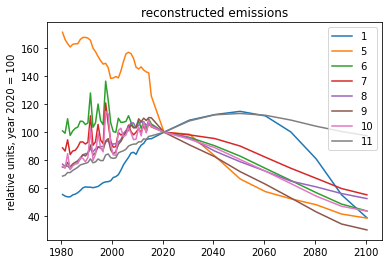

In [4]:
for specie_index in [1, 5, 6, 7, 8, 9, 10, 11]:
    pl.plot(
        np.arange(1980.5, 2101),
        100 * emissions_out[scenario][230:351, specie_index] / emissions_out[scenario][270, specie_index],
        label=specie_index,
    )
pl.legend()
pl.title('reconstructed emissions')
pl.ylabel('relative units, year 2020 = 100')

In [5]:
emissions_out

{'ssp245': array([[ 1.75000000e+03,  2.59244179e-03,  8.11267109e-02, ...,
          0.00000000e+00,  1.05087730e+02,  4.27574490e+03],
        [ 1.75100000e+03,  2.59253543e-03,  8.26192087e-02, ...,
          0.00000000e+00,  1.05107200e+02,  4.27676850e+03],
        [ 1.75200000e+03,  2.59363692e-03,  8.41391642e-02, ...,
          0.00000000e+00,  1.05125020e+02,  4.27770490e+03],
        ...,
        [ 2.10800000e+03,  3.73923069e+00, -1.09965400e+00, ...,
          7.66800000e-03,  1.07602299e+02,  4.36670685e+03],
        [ 2.10900000e+03,  3.71289808e+00, -1.07347176e+00, ...,
          7.61400000e-03,  1.06844536e+02,  4.33595539e+03],
        [ 2.11000000e+03,  3.68656547e+00, -1.04728952e+00, ...,
          7.56000000e-03,  1.06086773e+02,  4.30520393e+03]]),
 'ch4_30': array([[ 1.75000000e+03,  2.59244179e-03,  8.11267109e-02, ...,
          0.00000000e+00,  1.05087730e+02,  4.27574490e+03],
        [ 1.75100000e+03,  2.59253543e-03,  8.26192087e-02, ...,
          0.000000

## 30%, 40% and 50% methane reductions by 2030 

We will use SSP2-4.5 as a baseline and assume a linear decline 2020 to 2030, with 30, 40 or 50% below SSP2-4.5 values in all future years.

We may instead want to just keep 2030 levels constant. This is a discussion above my pay grade.

- 380 MtCH4/yr as "business as usual" in 2030 in ETC Keeping 1.5C Alive
- 382 MtCH4/yr in 2030 in SSP2-4.5

it's therefore OK to assume SSP2-4.5 values as our baseline.

In [6]:
for reduct in [30, 40, 50]:
    emissions_out['ch4_{}'.format(reduct)] = copy.copy(emissions_out['ssp245'])
    emissions_out['ch4_{}'.format(reduct)][280:,3] = emissions_out['ch4_{}'.format(reduct)][280:,3] * (1-reduct*0.01)
    emissions_out['ch4_{}'.format(reduct)][270:281,3] = np.linspace(1,0,11)*emissions_out['ch4_{}'.format(reduct)][270,3] + np.linspace(0,1,11)*emissions_out['ch4_{}'.format(reduct)][280,3]

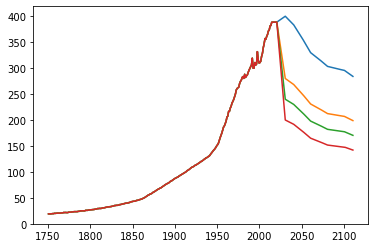

In [7]:
pl.plot(np.arange(1750.5, 2111), emissions_out['ssp245'][:,3])
pl.plot(np.arange(1750.5, 2111), emissions_out['ch4_30'][:,3])
pl.plot(np.arange(1750.5, 2111), emissions_out['ch4_40'][:,3])
pl.plot(np.arange(1750.5, 2111), emissions_out['ch4_50'][:,3])

## Halting deforestation in 2022

Easiest to set land use CO2 emissions to zero in 2022. This might be an overall warming with respect to SSP2-4.5, because of the assumption that land use forcing scales with cumulative land use CO2.

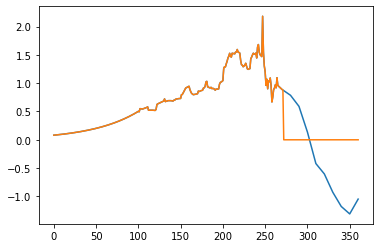

In [8]:
emissions_out['co2afolu_0'][272:,2] = 0
pl.plot(emissions_out['ssp245'][:,2])
pl.plot(emissions_out['co2afolu_0'][:,2])

## Coal phase out by 2030

this will be a little more difficult, and requires us to go back to the IIASA Scenario Database to estimate the coal-attributable emissions. Luckily for us, which makes it easy, in SSP2-4.5 coal consumption is pretty flat from 2020 to 2030.

I will use CEDS data to estimate fugitive emissions as well as direct emissions attributed to coal. This is because IEA data isn't granular enough and isn't publicly available.

We assume simply that coal is replaced by a zero-carbon alternative.

Because of units and other thorniniess, we'll do it the slow way, species by species.

We won't bother with NH3, as it's almost all agricultural and we'll be seriously double-counting.

### CO2

In [9]:
emissions_out['coal-phase-out'][269,1] * 44/12  # SSP2-4.5 emissions estimate in GtCO2 for 2019

37.037560379999995

In [10]:
# CEDS emissions 2019 in ktCO2
ceds_co2_sector_df = pd.read_csv('../data_input/ceds-20210421/CO2_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_co2_sector_df.set_index('sector', inplace=True)
ceds_co2_sector_df.sum().loc['X2019']

36040300.69024082

What we'll do here is take the coal emissions directly attributable from combustion, plus any fugitive emissions from solid fuels, divide by the total CO2 emissions to get a coal attributable fraction, then 

This number is about 10% lower than IEA coal attributable emissions, but (1) their data isn't public and (2) it gives a different number for total emissions to CEDS.

In [11]:
# quick verification that the numbers agree
ceds_co2_fuel_df = pd.read_csv('../data_input/ceds-20210421/CO2_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_co2_fuel_df.set_index('fuel', inplace=True)
ceds_co2_fuel_df.sum().loc['X2019']

36040300.690240785

In [12]:
coal_co2 = (
    ceds_co2_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_co2_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_co2_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_co2_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_co2

12813857.949406603

In [13]:
# this is the "harmonized" coal ktCO2 emissions in SSP2-4.5
coal_co2_ssp245_harmonized = coal_co2 / ceds_co2_fuel_df.sum().loc['X2019'] * 1e6 * emissions_out['coal-phase-out'][269,1] * 44/12
coal_co2_ssp245_harmonized

13168426.134424664

Now, we can estimate an emissions factor by looking at the primary energy supply from coal in SSP2-4.5. We use 2020 rather than 2019, as 2019 is not supplied in the scenario.

In [14]:
message_ssp245_df = pd.read_csv('../data_input/iiasa/ssp245-iam-database.csv')
message_ssp245_df.set_index('VARIABLE', inplace=True)
message_ssp245_df

,MODEL,SCENARIO,REGION,UNIT,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
VARIABLE,,,,,,,,,,,,,,,
Agricultural Demand|Crops,MESSAGE-GLOBIOM,SSP2-45,World,million t DM/yr,2562.601266,2743.381807,3248.917997,3745.438630,4159.658312,4492.174743,4712.009911,4834.685184,4875.660229,4818.471005,4687.290137
Agricultural Demand|Livestock,MESSAGE-GLOBIOM,SSP2-45,World,million t DM/yr,216.129997,233.117496,275.839085,317.729577,352.634669,380.686753,399.023954,409.914104,414.819298,411.139333,401.639483
Agricultural Production|Crops|Energy,MESSAGE-GLOBIOM,SSP2-45,World,million t DM/yr,0.000000,0.000000,938.601455,1058.571341,1304.838008,1709.238008,2318.038008,3309.945797,4596.479130,5835.726789,6815.054091
Agricultural Production|Crops|Non-Energy,MESSAGE-GLOBIOM,SSP2-45,World,million t DM/yr,2734.478368,3032.884054,3541.323517,4038.069092,4452.318462,4784.848480,5004.669273,5127.300778,5168.194521,5110.846865,4979.390465
Agricultural Production|Livestock,MESSAGE-GLOBIOM,SSP2-45,World,million t DM/yr,216.129997,233.117496,275.839085,317.729577,352.634669,380.686753,399.023954,409.914104,414.819298,411.139333,401.639483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Secondary Energy|Liquids|Gas,MESSAGE-GLOBIOM,SSP2-45,World,EJ/yr,0.000000,0.000000,0.936000,2.845000,3.500000,2.728000,1.160000,0.123000,0.513000,0.513000,0.000000
Secondary Energy|Liquids|Gas|w/ CCS,MESSAGE-GLOBIOM,SSP2-45,World,EJ/yr,0.000000,0.000000,0.000000,0.000000,0.000000,0.247000,0.247000,0.123000,0.513000,0.513000,0.000000
Secondary Energy|Liquids|Gas|w/o CCS,MESSAGE-GLOBIOM,SSP2-45,World,EJ/yr,0.000000,0.000000,0.936000,2.845000,3.500000,2.481000,0.913000,0.000000,0.000000,0.000000,0.000000


In [15]:
message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']  # EJ/yr

138.074

In [16]:
# kgCO2 / MJ for coal
emissions_factor_coal_co2 = (
    coal_co2_ssp245_harmonized * 1e-6 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_co2

0.09537223615180745

In [17]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_co2 = emissions_factor_coal_co2 * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':] / (44/12)
ssp245_coal_co2

2020    3.591389
2030    3.595134
2040    2.975952
2050    2.424085
2060    2.076739
2070    1.724633
2080    1.354789
2090    0.969025
2100    0.448761
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [18]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_co2.loc['2020'] = 0
ssp245_coal_co2

2020           0
2030    3.595134
2040    2.975952
2050    2.424085
2060    2.076739
2070    1.724633
2080    1.354789
2090    0.969025
2100    0.448761
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [19]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_co2.values)
ssp245_coal_co2_interp = f(np.arange(2020,2101))
ssp245_coal_co2_interp

array([0.        , 0.35951345, 0.71902689, 1.07854034, 1.43805379,
       1.79756724, 2.15708068, 2.51659413, 2.87610758, 3.23562103,
       3.59513447, 3.53321622, 3.47129796, 3.4093797 , 3.34746145,
       3.28554319, 3.22362493, 3.16170668, 3.09978842, 3.03787016,
       2.97595191, 2.92076519, 2.86557848, 2.81039177, 2.75520506,
       2.70001835, 2.64483164, 2.58964493, 2.53445822, 2.47927151,
       2.4240848 , 2.38935023, 2.35461566, 2.31988109, 2.28514652,
       2.25041195, 2.21567739, 2.18094282, 2.14620825, 2.11147368,
       2.07673911, 2.04152855, 2.00631799, 1.97110742, 1.93589686,
       1.9006863 , 1.86547574, 1.83026517, 1.79505461, 1.75984405,
       1.72463349, 1.687649  , 1.65066451, 1.61368003, 1.57669554,
       1.53971106, 1.50272657, 1.46574208, 1.4287576 , 1.39177311,
       1.35478863, 1.31621229, 1.27763595, 1.23905962, 1.20048328,
       1.16190695, 1.12333061, 1.08475428, 1.04617794, 1.00760161,
       0.96902527, 0.91699885, 0.86497243, 0.812946  , 0.76091

In [20]:
emissions_out['coal-phase-out'][270:351,1] = emissions_out['coal-phase-out'][270:351,1] - ssp245_coal_co2_interp
emissions_out['coal-phase-out'][351:,1] = emissions_out['coal-phase-out'][351:,1] - ssp245_coal_co2_interp[-1]

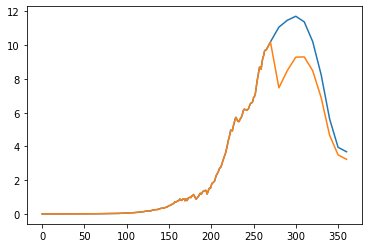

In [21]:
# as we can see this trajectory is a little artificial, because we have assumed that all coal is replaced by a zero
# carbon fuel. In the real world much of the additional capacity will be gas.
pl.plot(emissions_out['ssp245'][:,1])
pl.plot(emissions_out['coal-phase-out'][:,1])

### CH4

In [22]:
# CEDS emissions 2019 in ktCH4
ceds_ch4_sector_df = pd.read_csv('../data_input/ceds-20210421/CH4_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_ch4_sector_df.set_index('sector', inplace=True)
ceds_ch4_sector_df.sum().loc['X2019']

362144.4058474003

In [23]:
# quick verification that the numbers agree
ceds_ch4_fuel_df = pd.read_csv('../data_input/ceds-20210421/CH4_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_ch4_fuel_df.set_index('fuel', inplace=True)
ceds_ch4_fuel_df.sum().loc['X2019']

362144.40584740025

In [24]:
coal_ch4 = (
    ceds_ch4_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_ch4_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_ch4_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_ch4_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_ch4

46850.33863883298

In [25]:
# this is the "harmonized" coal MtCH4 emissions in SSP2-4.5.
coal_ch4_ssp245_harmonized = coal_ch4 / ceds_ch4_fuel_df.sum().loc['X2019'] * emissions_out['coal-phase-out'][269,3]
coal_ch4_ssp245_harmonized

50.20651399900717

Now, we can estimate an emissions factor by looking at the primary energy supply from coal in SSP2-4.5. We use 2020 rather than 2019, as 2019 is not supplied in the scenario.

In [26]:
# kgCH4 / MJ for coal
emissions_factor_coal_ch4 = (
    coal_ch4_ssp245_harmonized / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_ch4

0.36362033401659377

In [27]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_ch4 = emissions_factor_coal_ch4 * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':]
ssp245_coal_ch4

2020    50.206514
2030    50.258875
2040    41.602893
2050    33.887961
2060    29.032175
2070    24.109846
2080    18.939529
2090    13.546676
2100     6.273542
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [28]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_ch4.loc['2020'] = 0
ssp245_coal_ch4

2020            0
2030    50.258875
2040    41.602893
2050    33.887961
2060    29.032175
2070    24.109846
2080    18.939529
2090    13.546676
2100     6.273542
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [29]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_ch4.values)
ssp245_coal_ch4_interp = f(np.arange(2020,2101))
ssp245_coal_ch4_interp

array([ 0.        ,  5.02588753, 10.05177507, 15.0776626 , 20.10355013,
       25.12943766, 30.1553252 , 35.18121273, 40.20710026, 45.23298779,
       50.25887533, 49.39327712, 48.52767892, 47.66208071, 46.79648251,
       45.9308843 , 45.0652861 , 44.19968789, 43.33408969, 42.46849148,
       41.60289328, 40.83140001, 40.05990675, 39.28841349, 38.51692023,
       37.74542696, 36.9739337 , 36.20244044, 35.43094717, 34.65945391,
       33.88796065, 33.40238205, 32.91680346, 32.43122487, 31.94564627,
       31.46006768, 30.97448908, 30.48891049, 30.0033319 , 29.5177533 ,
       29.03217471, 28.53994186, 28.04770902, 27.55547617, 27.06324332,
       26.57101048, 26.07877763, 25.58654479, 25.09431194, 24.60207909,
       24.10984625, 23.59281449, 23.07578274, 22.55875099, 22.04171924,
       21.52468748, 21.00765573, 20.49062398, 19.97359222, 19.45656047,
       18.93952872, 18.4002434 , 17.86095808, 17.32167277, 16.78238745,
       16.24310213, 15.70381681, 15.1645315 , 14.62524618, 14.08

In [30]:
emissions_out['coal-phase-out'][270:351,3] = emissions_out['coal-phase-out'][270:351,3] - ssp245_coal_ch4_interp
emissions_out['coal-phase-out'][351:,3] = emissions_out['coal-phase-out'][351:,3] - ssp245_coal_ch4_interp[-1]

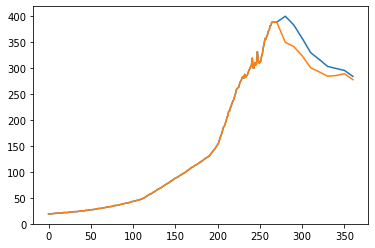

In [31]:
# as we can see this trajectory is a little artificial, because we have assumed that all coal is replaced by a zero
# carbon fuel. In the real world much of the additional capacity will be gas.
pl.plot(emissions_out['ssp245'][:,3])
pl.plot(emissions_out['coal-phase-out'][:,3])

### N2O

In [32]:
emissions_out['coal-phase-out'][269,4] * 44/28  # SSP2-4.5 emissions estimate in MtN2O for 2019

11.238282264

In [33]:
# CEDS emissions 2019 in ktN2O
ceds_n2o_sector_df = pd.read_csv('../data_input/ceds-20210421/N2O_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_n2o_sector_df.set_index('sector', inplace=True)
ceds_n2o_sector_df.sum().loc['X2019']

9719.04424271182

In [34]:
# quick verification that the numbers agree
ceds_n2o_fuel_df = pd.read_csv('../data_input/ceds-20210421/N2O_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_n2o_fuel_df.set_index('fuel', inplace=True)
ceds_n2o_fuel_df.sum().loc['X2019']

9719.044242711823

In [35]:
coal_n2o = (
    ceds_n2o_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_n2o_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_n2o_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_n2o_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_n2o

335.0576460506043

In [36]:
# this is the "harmonized" coal ktN2O emissions in SSP2-4.5
coal_n2o_ssp245_harmonized = coal_n2o / ceds_n2o_fuel_df.sum().loc['X2019'] * 1e3 * emissions_out['coal-phase-out'][269,4] * 44/28
coal_n2o_ssp245_harmonized

387.43237575564814

In [37]:
# kgN2O / MJ for coal
emissions_factor_coal_n2o = (
    coal_n2o_ssp245_harmonized * 1e-3 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_n2o

0.00280597632976265

In [38]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_n2o = emissions_factor_coal_n2o * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':] / (44/28)
ssp245_coal_n2o

2020    0.246548
2030    0.246805
2040    0.204298
2050    0.166413
2060    0.142568
2070    0.118396
2080    0.093006
2090    0.066523
2100    0.030807
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [39]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_n2o.loc['2020'] = 0

In [40]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_n2o.values)
ssp245_coal_n2o_interp = f(np.arange(2020,2101))
ssp245_coal_n2o_interp

array([0.        , 0.0246805 , 0.049361  , 0.0740415 , 0.098722  ,
       0.1234025 , 0.148083  , 0.1727635 , 0.197444  , 0.2221245 ,
       0.246805  , 0.24255433, 0.23830366, 0.23405299, 0.22980232,
       0.22555165, 0.22130098, 0.2170503 , 0.21279963, 0.20854896,
       0.20429829, 0.20050974, 0.19672118, 0.19293263, 0.18914408,
       0.18535553, 0.18156697, 0.17777842, 0.17398987, 0.17020132,
       0.16641276, 0.16402824, 0.16164373, 0.15925921, 0.15687469,
       0.15449017, 0.15210565, 0.14972113, 0.14733661, 0.14495209,
       0.14256758, 0.14015038, 0.13773318, 0.13531599, 0.13289879,
       0.1304816 , 0.1280644 , 0.12564721, 0.12323001, 0.12081282,
       0.11839562, 0.11585665, 0.11331767, 0.1107787 , 0.10823972,
       0.10570075, 0.10316177, 0.1006228 , 0.09808382, 0.09554485,
       0.09300587, 0.09035762, 0.08770936, 0.08506111, 0.08241285,
       0.0797646 , 0.07711634, 0.07446809, 0.07181983, 0.06917158,
       0.06652332, 0.06295172, 0.05938012, 0.05580852, 0.05223

In [41]:
emissions_out['coal-phase-out'][270:351,4] = emissions_out['coal-phase-out'][270:351,4] - ssp245_coal_n2o_interp
emissions_out['coal-phase-out'][351:,4] = emissions_out['coal-phase-out'][351:,4] - ssp245_coal_n2o_interp[-1]

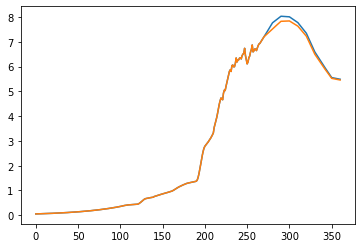

In [42]:
pl.plot(emissions_out['ssp245'][:,4])
pl.plot(emissions_out['coal-phase-out'][:,4])

### SO2

In [43]:
emissions_out['coal-phase-out'][269,5] * 64/32  # SSP2-4.5 emissions estimate in MtSO2 for 2019

84.21911852

In [44]:
# CEDS emissions 2019 in ktSO2
ceds_so2_sector_df = pd.read_csv('../data_input/ceds-20210421/SO2_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_so2_sector_df.set_index('sector', inplace=True)
ceds_so2_sector_df.sum().loc['X2019']

83124.14576034255

In [45]:
# quick verification that the numbers agree
ceds_so2_fuel_df = pd.read_csv('../data_input/ceds-20210421/SO2_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_so2_fuel_df.set_index('fuel', inplace=True)
ceds_so2_fuel_df.sum().loc['X2019']

83124.14576034262

In [46]:
coal_so2 = (
    ceds_so2_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_so2_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_so2_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_so2_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_so2

33210.7155290149

In [47]:
# this is the "harmonized" coal ktSO2 emissions in SSP2-4.5
coal_so2_ssp245_harmonized = coal_so2 / ceds_so2_fuel_df.sum().loc['X2019'] * 1e3 * emissions_out['coal-phase-out'][269,5] * 64/32
coal_so2_ssp245_harmonized

33648.19164982637

In [48]:
# kgSO2 / MJ for coal
emissions_factor_coal_so2 = (
    coal_so2_ssp245_harmonized * 1e-3 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_so2

0.24369679773039357

In [49]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_so2 = emissions_factor_coal_so2 * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':] / (64/32)
ssp245_coal_so2

2020    16.824096
2030    16.841642
2040    13.941041
2050    11.355783
2060      9.72862
2070     8.079158
2080     6.346596
2090     4.539462
2100      2.10225
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [50]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_so2.loc['2020'] = 0

In [51]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_so2.values)
ssp245_coal_so2_interp = f(np.arange(2020,2101))
ssp245_coal_so2_interp

array([ 0.        ,  1.6841642 ,  3.3683284 ,  5.0524926 ,  6.7366568 ,
        8.420821  , 10.1049852 , 11.7891494 , 13.4733136 , 15.15747779,
       16.84164199, 16.55158188, 16.26152177, 15.97146165, 15.68140154,
       15.39134143, 15.10128131, 14.8112212 , 14.52116109, 14.23110097,
       13.94104086, 13.68251511, 13.42398936, 13.16546362, 12.90693787,
       12.64841212, 12.38988637, 12.13136062, 11.87283488, 11.61430913,
       11.35578338, 11.19306703, 11.03035068, 10.86763433, 10.70491797,
       10.54220162, 10.37948527, 10.21676892, 10.05405257,  9.89133621,
        9.72861986,  9.56367368,  9.39872751,  9.23378133,  9.06883515,
        8.90388897,  8.7389428 ,  8.57399662,  8.40905044,  8.24410426,
        8.07915809,  7.90590185,  7.73264561,  7.55938937,  7.38613313,
        7.2128769 ,  7.03962066,  6.86636442,  6.69310818,  6.51985194,
        6.3465957 ,  6.16588234,  5.98516898,  5.80445562,  5.62374226,
        5.4430289 ,  5.26231554,  5.08160218,  4.90088882,  4.72

In [52]:
emissions_out['coal-phase-out'][270:351,5] = emissions_out['coal-phase-out'][270:351,5] - ssp245_coal_so2_interp
emissions_out['coal-phase-out'][351:,5] = emissions_out['coal-phase-out'][351:,5] - ssp245_coal_so2_interp[-1]

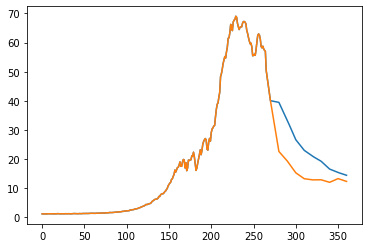

In [53]:
pl.plot(emissions_out['ssp245'][:,5])
pl.plot(emissions_out['coal-phase-out'][:,5])

## CO

In [54]:
emissions_out['coal-phase-out'][269,6] # SSP2-4.5 emissions estimate in MtCO for 2019

892.88514646

In [55]:
# CEDS emissions 2019 in ktCO
ceds_co_sector_df = pd.read_csv('../data_input/ceds-20210421/CO_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_co_sector_df.set_index('sector', inplace=True)
ceds_co_sector_df.sum().loc['X2019']

528838.1644756579

In [56]:
# quick verification that the numbers agree
ceds_co_fuel_df = pd.read_csv('../data_input/ceds-20210421/CO_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_co_fuel_df.set_index('fuel', inplace=True)
ceds_co_fuel_df.sum().loc['X2019']

528838.1644756572

In [57]:
coal_co = (
    ceds_co_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_co_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_co_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_co_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_co

119272.38155989768

In [58]:
# this is the "harmonized" coal ktCO emissions in SSP2-4.5. Some of this is biomass based, but we don't have this info.
coal_co_ssp245_harmonized = coal_co / ceds_co_fuel_df.sum().loc['X2019'] * 1e3 * emissions_out['coal-phase-out'][269,6]
coal_co_ssp245_harmonized

201378.31388045437

In [59]:
# kgCO / MJ for coal
emissions_factor_coal_co = (
    coal_co_ssp245_harmonized * 1e-3 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_co

1.458481060014589

In [60]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_co = emissions_factor_coal_co * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':]
ssp245_coal_co

2020    201.378314
2030    201.588335
2040    166.869194
2050    135.924601
2060    116.448045
2070     96.704587
2080     75.966444
2090     54.335712
2100     25.163174
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [61]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_co.loc['2020'] = 0

In [62]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_co.values)
ssp245_coal_co_interp = f(np.arange(2020,2101))
ssp245_coal_co_interp

array([  0.        ,  20.15883352,  40.31766703,  60.47650055,
        80.63533406, 100.79416758, 120.95300109, 141.11183461,
       161.27066812, 181.42950164, 201.58833515, 198.11642099,
       194.64450683, 191.17259266, 187.7006785 , 184.22876434,
       180.75685017, 177.28493601, 173.81302185, 170.34110768,
       166.86919352, 163.77473425, 160.68027499, 157.58581572,
       154.49135646, 151.39689719, 148.30243793, 145.20797866,
       142.1135194 , 139.01906013, 135.92460087, 133.97694526,
       132.02928965, 130.08163405, 128.13397844, 126.18632283,
       124.23866722, 122.29101162, 120.34335601, 118.3957004 ,
       116.44804479, 114.47369898, 112.49935317, 110.52500736,
       108.55066155, 106.57631574, 104.60196993, 102.62762412,
       100.65327831,  98.6789325 ,  96.70458668,  94.63077247,
        92.55695825,  90.48314403,  88.40932981,  86.33551559,
        84.26170137,  82.18788715,  80.11407293,  78.04025871,
        75.96644449,  73.80337123,  71.64029797,  69.47

In [63]:
emissions_out['coal-phase-out'][270:351,6] = emissions_out['coal-phase-out'][270:351,6] - ssp245_coal_co_interp
emissions_out['coal-phase-out'][351:,6] = emissions_out['coal-phase-out'][351:,6] - ssp245_coal_co_interp[-1]

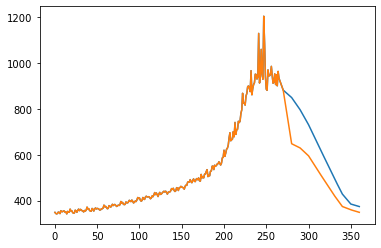

In [64]:
pl.plot(emissions_out['ssp245'][:,6])
pl.plot(emissions_out['coal-phase-out'][:,6])

### VOC

In [65]:
emissions_out['coal-phase-out'][269,7]  # SSP2-4.5 emissions estimate in MtVOC for 2019

220.53307162000002

In [66]:
# CEDS emissions 2019 in ktVOC
ceds_voc_sector_df = pd.read_csv('../data_input/ceds-20210421/NMVOC_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_voc_sector_df.set_index('sector', inplace=True)
ceds_voc_sector_df.sum().loc['X2019']

146667.54546049517

In [67]:
# quick verification that the numbers agree
ceds_voc_fuel_df = pd.read_csv('../data_input/ceds-20210421/NMVOC_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_voc_fuel_df.set_index('fuel', inplace=True)
ceds_voc_fuel_df.sum().loc['X2019']

146667.54546049546

In [68]:
coal_voc = (
    ceds_voc_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_voc_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_voc_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_voc_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_voc

22339.99094032276

In [69]:
# this is the "harmonized" coal ktVOC emissions in SSP2-4.5
coal_voc_ssp245_harmonized = coal_voc / ceds_voc_fuel_df.sum().loc['X2019'] * 1e3 * emissions_out['coal-phase-out'][269,7]
coal_voc_ssp245_harmonized

33590.98160785234

In [70]:
# kgVOC / MJ for coal
emissions_factor_coal_voc = (
    coal_voc_ssp245_harmonized * 1e-3 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_voc

0.24328245439295115

In [71]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_voc = emissions_factor_coal_voc * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':]
ssp245_coal_voc

2020    33.590982
2030    33.626014
2040    27.834675
2050    22.672952
2060    19.424158
2070    16.130843
2080     12.67161
2090     9.063488
2100     4.197352
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [72]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_voc.loc['2020'] = 0

In [73]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_voc.values)
ssp245_coal_voc_interp = f(np.arange(2020,2101))
ssp245_coal_voc_interp

array([ 0.        ,  3.36260143,  6.72520286, 10.08780428, 13.45040571,
       16.81300714, 20.17560857, 23.53821   , 26.90081143, 30.26341285,
       33.62601428, 33.0468804 , 32.46774652, 31.88861263, 31.30947875,
       30.73034487, 30.15121099, 29.5720771 , 28.99294322, 28.41380934,
       27.83467545, 27.31850307, 26.80233069, 26.2861583 , 25.76998592,
       25.25381354, 24.73764115, 24.22146877, 23.70529639, 23.189124  ,
       22.67295162, 22.34807223, 22.02319284, 21.69831345, 21.37343406,
       21.04855467, 20.72367528, 20.39879589, 20.0739165 , 19.74903711,
       19.42415772, 19.09482627, 18.76549481, 18.43616335, 18.10683189,
       17.77750043, 17.44816897, 17.11883751, 16.78950606, 16.4601746 ,
       16.13084314, 15.78491982, 15.43899649, 15.09307317, 14.74714985,
       14.40122653, 14.05530321, 13.70937989, 13.36345656, 13.01753324,
       12.67160992, 12.31079771, 11.9499855 , 11.5891733 , 11.22836109,
       10.86754888, 10.50673667, 10.14592446,  9.78511225,  9.42

In [74]:
emissions_out['coal-phase-out'][270:351,7] = emissions_out['coal-phase-out'][270:351,7] - ssp245_coal_voc_interp
emissions_out['coal-phase-out'][351:,7] = emissions_out['coal-phase-out'][351:,7] - ssp245_coal_voc_interp[-1]

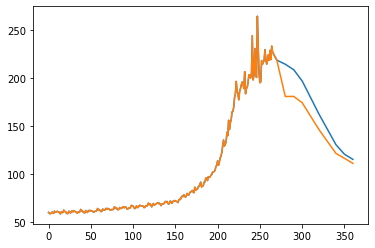

In [75]:
pl.plot(emissions_out['ssp245'][:,7])
pl.plot(emissions_out['coal-phase-out'][:,7])

### NOx

Another unit brain tax

In [76]:
emissions_out['coal-phase-out'][269,8] * 46/14  # SSP2-4.5 emissions estimate in MtNO2 for 2019

149.55938608

In [77]:
# CEDS emissions 2019 in ktNO2
ceds_nox_sector_df = pd.read_csv('../data_input/ceds-20210421/NOx_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_nox_sector_df.set_index('sector', inplace=True)
ceds_nox_sector_df.sum().loc['X2019']

120954.5103374913

In [78]:
# quick verification that the numbers agree
ceds_nox_fuel_df = pd.read_csv('../data_input/ceds-20210421/NOx_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_nox_fuel_df.set_index('fuel', inplace=True)
ceds_nox_fuel_df.sum().loc['X2019']

120954.51033749139

In [79]:
coal_nox = (
    ceds_nox_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_nox_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_nox_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_nox_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_nox

21662.357980535377

In [80]:
# this is the "harmonized" coal ktNO2 emissions in SSP2-4.5
coal_nox_ssp245_harmonized = coal_nox / ceds_nox_fuel_df.sum().loc['X2019'] * 1e3 * emissions_out['coal-phase-out'][269,8] * 46/14
coal_nox_ssp245_harmonized

26785.350555132125

In [81]:
# kgNO2 / MJ for coal
emissions_factor_coal_nox = (
    coal_nox_ssp245_harmonized * 1e-3 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_nox

0.19399271807242582

In [82]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_nox = emissions_factor_coal_nox * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':] / (46/14)
ssp245_coal_nox

2020    8.152063
2030    8.160565
2040    6.755088
2050    5.502409
2060    4.713972
2070    3.914731
2080    3.075223
2090    2.199582
2100    1.018639
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [83]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_nox.loc['2020'] = 0

In [84]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_nox.values)
ssp245_coal_nox_interp = f(np.arange(2020,2101))
ssp245_coal_nox_interp

array([0.        , 0.81605652, 1.63211303, 2.44816955, 3.26422606,
       4.08028258, 4.89633909, 5.71239561, 6.52845212, 7.34450864,
       8.16056515, 8.02001743, 7.87946971, 7.73892198, 7.59837426,
       7.45782653, 7.31727881, 7.17673108, 7.03618336, 6.89563564,
       6.75508791, 6.62982007, 6.50455222, 6.37928437, 6.25401653,
       6.12874868, 6.00348084, 5.87821299, 5.75294515, 5.6276773 ,
       5.50240946, 5.42356575, 5.34472205, 5.26587835, 5.18703465,
       5.10819095, 5.02934725, 4.95050355, 4.87165984, 4.79281614,
       4.71397244, 4.63404829, 4.55412413, 4.47419997, 4.39427582,
       4.31435166, 4.2344275 , 4.15450335, 4.07457919, 3.99465503,
       3.91473088, 3.83078011, 3.74682934, 3.66287857, 3.5789278 ,
       3.49497703, 3.41102626, 3.32707549, 3.24312471, 3.15917394,
       3.07522317, 2.98765908, 2.90009498, 2.81253089, 2.72496679,
       2.6374027 , 2.5498386 , 2.4622745 , 2.37471041, 2.28714631,
       2.19958222, 2.08148788, 1.96339355, 1.84529922, 1.72720

In [85]:
emissions_out['coal-phase-out'][270:351,8] = emissions_out['coal-phase-out'][270:351,8] - ssp245_coal_nox_interp
emissions_out['coal-phase-out'][351:,8] = emissions_out['coal-phase-out'][351:,8] - ssp245_coal_nox_interp[-1]

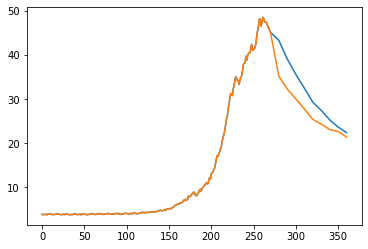

In [86]:
pl.plot(emissions_out['ssp245'][:,8])
pl.plot(emissions_out['coal-phase-out'][:,8])

### BC

In [87]:
emissions_out['coal-phase-out'][269,9] # SSP2-4.5 emissions estimate in MtBC for 2019

9.002700022600001

In [88]:
# CEDS emissions 2019 in ktBC
ceds_bc_sector_df = pd.read_csv('../data_input/ceds-20210421/BC_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_bc_sector_df.set_index('sector', inplace=True)
ceds_bc_sector_df.sum().loc['X2019']

5835.859939871475

In [89]:
# quick verification that the numbers agree
ceds_bc_fuel_df = pd.read_csv('../data_input/ceds-20210421/BC_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_bc_fuel_df.set_index('fuel', inplace=True)
ceds_bc_fuel_df.sum().loc['X2019']

5835.859939871478

In [90]:
coal_bc = (
    ceds_bc_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_bc_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_bc_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_bc_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_bc

737.8768965353879

In [91]:
# this is the "harmonized" coal ktBC emissions in SSP2-4.5
coal_bc_ssp245_harmonized = coal_bc / ceds_bc_fuel_df.sum().loc['X2019'] * 1e3 * emissions_out['coal-phase-out'][269,9]
coal_bc_ssp245_harmonized

1138.2871456064195

In [92]:
# kgBC / MJ for coal
emissions_factor_coal_bc = (
    coal_bc_ssp245_harmonized * 1e-3 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_bc

0.008244036861439657

In [93]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_bc = emissions_factor_coal_bc * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':]
ssp245_coal_bc

2020    1.138287
2030    1.139474
2040    0.943225
2050    0.768311
2060     0.65822
2070    0.546621
2080    0.429399
2090    0.307132
2100    0.142234
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [94]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_bc.loc['2020'] = 0

In [95]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_bc.values)
ssp245_coal_bc_interp = f(np.arange(2020,2101))
ssp245_coal_bc_interp

array([0.        , 0.11394743, 0.22789486, 0.34184229, 0.45578971,
       0.56973714, 0.68368457, 0.797632  , 0.91157943, 1.02552686,
       1.13947429, 1.11984936, 1.10022443, 1.0805995 , 1.06097457,
       1.04134964, 1.02172471, 1.00209978, 0.98247485, 0.96284992,
       0.94322499, 0.92573362, 0.90824224, 0.89075087, 0.8732595 ,
       0.85576812, 0.83827675, 0.82078538, 0.80329401, 0.78580263,
       0.76831126, 0.75730217, 0.74629309, 0.735284  , 0.72427491,
       0.71326583, 0.70225674, 0.69124765, 0.68023856, 0.66922948,
       0.65822039, 0.64706044, 0.63590049, 0.62474053, 0.61358058,
       0.60242063, 0.59126067, 0.58010072, 0.56894077, 0.55778082,
       0.54662086, 0.53489867, 0.52317647, 0.51145428, 0.49973208,
       0.48800988, 0.47628769, 0.46456549, 0.4528433 , 0.4411211 ,
       0.4293989 , 0.41717217, 0.40494544, 0.39271871, 0.38049198,
       0.36826525, 0.35603852, 0.34381179, 0.33158506, 0.31935832,
       0.30713159, 0.29064187, 0.27415215, 0.25766243, 0.24117

In [96]:
emissions_out['coal-phase-out'][270:351,9] = emissions_out['coal-phase-out'][270:351,9] - ssp245_coal_bc_interp
emissions_out['coal-phase-out'][351:,9] = emissions_out['coal-phase-out'][351:,9] - ssp245_coal_bc_interp[-1]

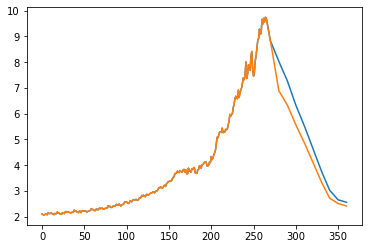

In [97]:
pl.plot(emissions_out['ssp245'][:,9])
pl.plot(emissions_out['coal-phase-out'][:,9])

### OC

In [98]:
emissions_out['coal-phase-out'][269,10]  # SSP2-4.5 emissions estimate in MtOC for 2019

33.681015318

In [99]:
# CEDS emissions 2019 in ktOC
ceds_oc_sector_df = pd.read_csv('../data_input/ceds-20210421/OC_global_CEDS_emissions_by_sector_2021_04_21.csv')
ceds_oc_sector_df.set_index('sector', inplace=True)
ceds_oc_sector_df.sum().loc['X2019']

13640.702929632738

In [100]:
# quick verification that the numbers agree
ceds_oc_fuel_df = pd.read_csv('../data_input/ceds-20210421/OC_global_CEDS_emissions_by_fuel_2021_04_21.csv')
ceds_oc_fuel_df.set_index('fuel', inplace=True)
ceds_oc_fuel_df.sum().loc['X2019']

13640.702929632744

In [101]:
coal_oc = (
    ceds_oc_fuel_df.loc['brown_coal', 'X2019'] +
    ceds_oc_fuel_df.loc['coal_coke', 'X2019'] +
    ceds_oc_fuel_df.loc['hard_coal', 'X2019'] +
    ceds_oc_sector_df.loc['1B1_Fugitive-solid-fuels','X2019']
)
coal_oc

1002.9956150704717

In [102]:
# this is the "harmonized" coal ktOC emissions in SSP2-4.5
coal_oc_ssp245_harmonized = coal_oc / ceds_oc_fuel_df.sum().loc['X2019'] * 1e3 * emissions_out['coal-phase-out'][269,10]
coal_oc_ssp245_harmonized

2476.5520405615134

In [103]:
# kgOC / MJ for coal
emissions_factor_coal_oc = (
    coal_oc_ssp245_harmonized * 1e-3 / message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020']
)
emissions_factor_coal_oc

0.017936411203858173

In [104]:
# convert the harmonized coal fraction back to FaIR emissions
ssp245_coal_oc = emissions_factor_coal_oc * message_ssp245_df.loc['Primary Energy|Coal|w/o CCS', '2020':]
ssp245_coal_oc

2020    2.476552
2030    2.479135
2040    2.052159
2050    1.671602
2060    1.432079
2070    1.189274
2080    0.934236
2090    0.668221
2100    0.309457
Name: Primary Energy|Coal|w/o CCS, dtype: object

In [105]:
# now, of course, it won't be an instant phase out, so the 2020 to 2030 is a linear ramp.
ssp245_coal_oc.loc['2020'] = 0

In [106]:
f = interp1d(np.arange(2020,2101,10), ssp245_coal_oc.values)
ssp245_coal_oc_interp = f(np.arange(2020,2101))
ssp245_coal_oc_interp

array([0.        , 0.24791349, 0.49582698, 0.74374047, 0.99165395,
       1.23956744, 1.48748093, 1.73539442, 1.98330791, 2.2312214 ,
       2.47913488, 2.43643726, 2.39373963, 2.351042  , 2.30834438,
       2.26564675, 2.22294912, 2.1802515 , 2.13755387, 2.09485624,
       2.05215862, 2.01410293, 1.97604725, 1.93799156, 1.89993588,
       1.8618802 , 1.82382451, 1.78576883, 1.74771315, 1.70965746,
       1.67160178, 1.6476495 , 1.62369721, 1.59974493, 1.57579264,
       1.55184036, 1.52788808, 1.50393579, 1.47998351, 1.45603123,
       1.43207894, 1.40779842, 1.3835179 , 1.35923738, 1.33495686,
       1.31067634, 1.28639582, 1.2621153 , 1.23783478, 1.21355426,
       1.18927374, 1.16376996, 1.13826618, 1.1127624 , 1.08725861,
       1.06175483, 1.03625105, 1.01074726, 0.98524348, 0.9597397 ,
       0.93423591, 0.90763442, 0.88103293, 0.85443144, 0.82782995,
       0.80122846, 0.77462697, 0.74802547, 0.72142398, 0.69482249,
       0.668221  , 0.63234459, 0.59646818, 0.56059177, 0.52471

In [107]:
emissions_out['coal-phase-out'][270:351,10] = emissions_out['coal-phase-out'][270:351,10] - ssp245_coal_oc_interp
emissions_out['coal-phase-out'][351:,10] = emissions_out['coal-phase-out'][351:,10] - ssp245_coal_oc_interp[-1]

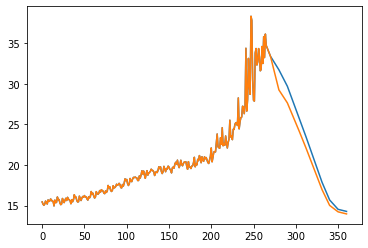

In [108]:
pl.plot(emissions_out['ssp245'][:,10])
pl.plot(emissions_out['coal-phase-out'][:,10])

## Everything

Coal phase out + 40% methane reduction + stopping deforestation

We will override the coal methane reductions with a 40% phase out of all methane.

In [109]:
emissions_out['all'] = copy.copy(emissions_out['coal-phase-out'])

In [110]:
emissions_out['all'][280:,3] = emissions_out['ssp245'][280:,3] * 0.6
emissions_out['all'][270:281,3] = np.linspace(1,0,11)*emissions_out['all'][270,3] + np.linspace(0,1,11)*emissions_out['all'][280,3]

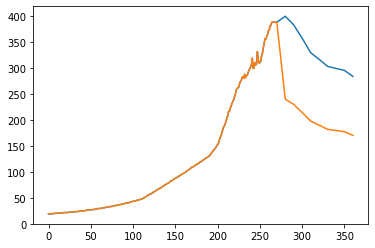

In [111]:
pl.plot(emissions_out['ssp245'][:,3])
pl.plot(emissions_out['all'][:,3])

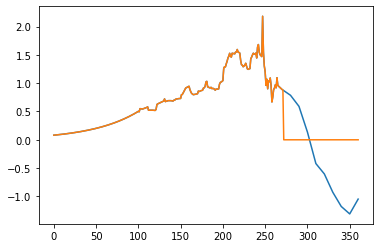

In [112]:
emissions_out['all'][272:,2] = 0
pl.plot(emissions_out['ssp245'][:,2])
pl.plot(emissions_out['all'][:,2])

## Finally, save out!

In [113]:
mkdir_p('../data_output/fair_emissions_files/')
for scenario in scenarios:
    np.savetxt('../data_output/fair_emissions_files/{}.csv'.format(scenario), emissions_out[scenario], delimiter=',')